In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025] AN2DL HW2/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/[2024-2025] AN2DL HW2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import additional libraries
import cv2
import csv
import scipy
from PIL import Image
from xml.dom import minidom
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
data = np.load("mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Outlier Removal

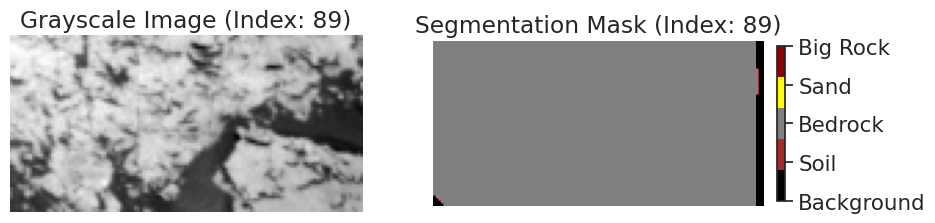

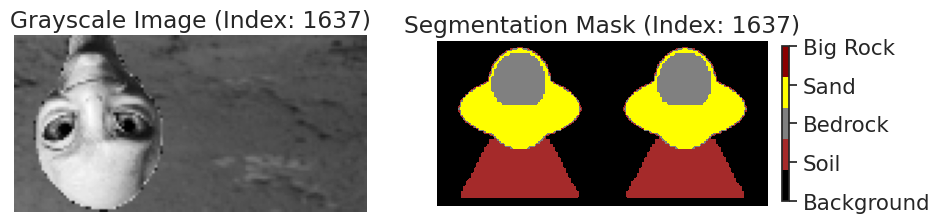

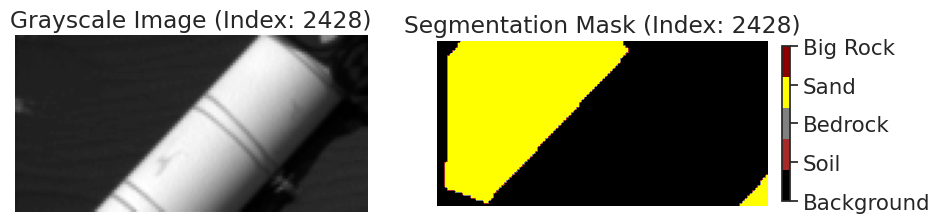

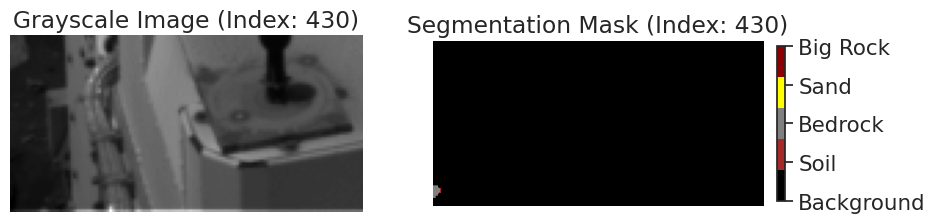

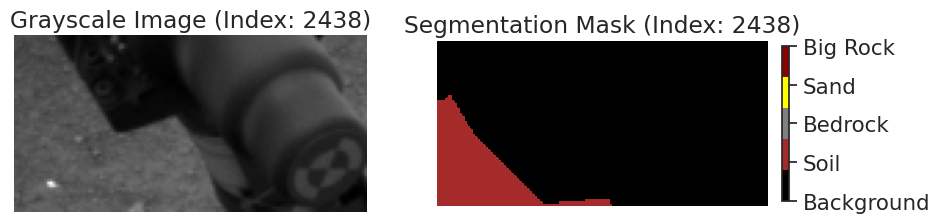

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

# Define a colormap for the segmentation mask
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

# Function to visualize an image and its segmentation mask with legend for labels
def visualize(index, images, labels):
    image = images[index]
    label = labels[index]

    plt.figure(figsize=(10, 5))

    # Display the grayscale image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Grayscale Image (Index: {index})")
    plt.axis("off")

    # Display the segmentation mask
    plt.subplot(1, 2, 2)
    im = plt.imshow(label, cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
    plt.title(f"Segmentation Mask (Index: {index})")
    plt.axis("off")

    # Add a color legend for the segmentation classes
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.022, pad=0.04)
    cbar.set_ticks(range(len(CLASS_LABELS)))
    cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

    plt.show()

# Generate 5 random indices
random_indices = np.random.choice(len(X_train), size=5, replace=False)

# Visualize the random examples
for i in random_indices:
    visualize(i, X_train, y_train)

In [ ]:
# Extract duplicate mask indices and remove them
def find_outliers(masks, specific_mask_index):
    """
    Find all indices where the mask matches the mask at the specific index.
    """
    specific_mask = masks[specific_mask_index]  # Get the reference mask
    duplicate_indices = []

    for i, mask in enumerate(masks):
        if np.array_equal(mask, specific_mask):  # Compare masks
            duplicate_indices.append(i)

    return duplicate_indices

# Example: Choose a specific index from the random visualization
reference_index = 1637
print(f"Using mask at index {reference_index} as the reference.")

# Find all duplicate masks
duplicate_indices = find_outliers(y_train, reference_index)

# Print outlier indices
print(f"Duplicate mask found at indices: {len(duplicate_indices)}")

Using mask at index 1637 as the reference.
Duplicate mask found at indices: 110


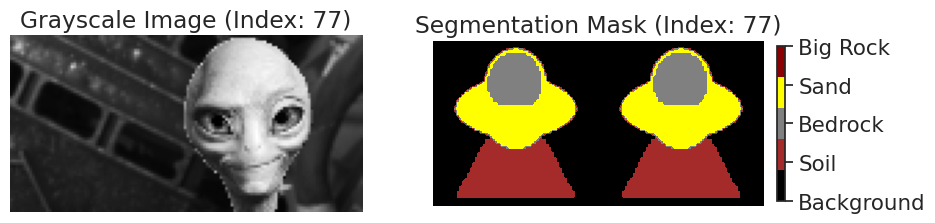

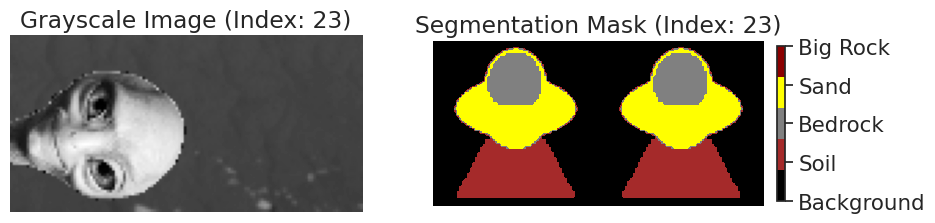

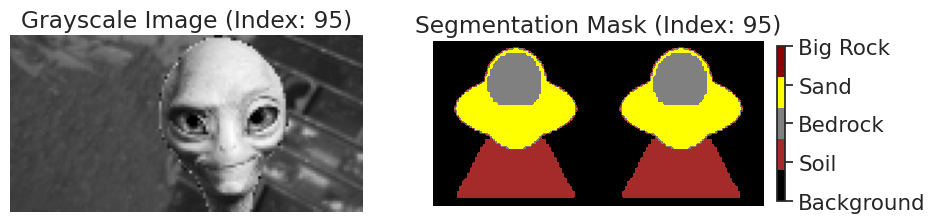

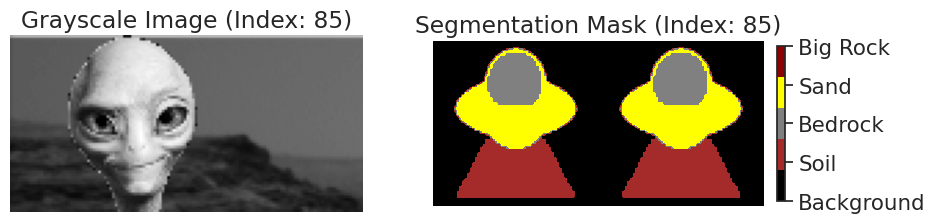

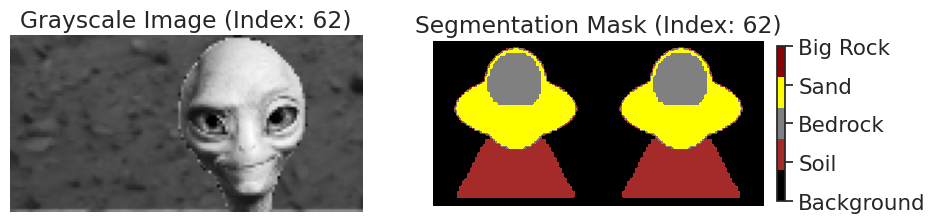

In [ ]:
# Generate 5 random indices
random_indices = np.random.choice(len(duplicate_indices), size=5, replace=False)

# Visualize the random examples
for i in random_indices:
    visualize(i, X_train[duplicate_indices], y_train[duplicate_indices])

In [ ]:
# Remove the duplicates from both X_train and y_train
X_train_cleaned = np.delete(X_train, duplicate_indices, axis=0)
y_train_cleaned = np.delete(y_train, duplicate_indices, axis=0)

print(f"Original dataset size: {len(X_train)}")
print(f"Cleaned dataset size: {len(X_train_cleaned)}")

Original dataset size: 2615
Cleaned dataset size: 2505


In [ ]:
print(duplicate_indices)

[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


In [ ]:
# Save the cleaned training set and the unmodified test set into a new .npz file
output_file = "mars_cleaned_dataset.npz"

# Save X_train_cleaned and y_train_cleaned separately instead of combining them
np.savez(output_file, X_train=X_train_cleaned, y_train=y_train_cleaned, X_test=X_test)

# Imbalance Analysis

In [ ]:
# Loading the cleaned dataset
data = np.load("mars_cleaned_dataset.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]

In [ ]:
# Define class labels for better readability
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Display class counts and percentages
print("Class Distribution:\n")
for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
    print(f"Class {i} ({class_labels[i]}):")
    print(f"    Pixels: {count}")
    print(f"    Frequency: {freq:.2f}%")

Class Distribution:

Class 0 (Background):
    Pixels: 4988826
    Frequency: 24.31%
Class 1 (Soil):
    Pixels: 6957538
    Frequency: 33.90%
Class 2 (Bedrock):
    Pixels: 4776810
    Frequency: 23.28%
Class 3 (Sand):
    Pixels: 3770823
    Frequency: 18.38%
Class 4 (Big Rock):
    Pixels: 26963
    Frequency: 0.13%


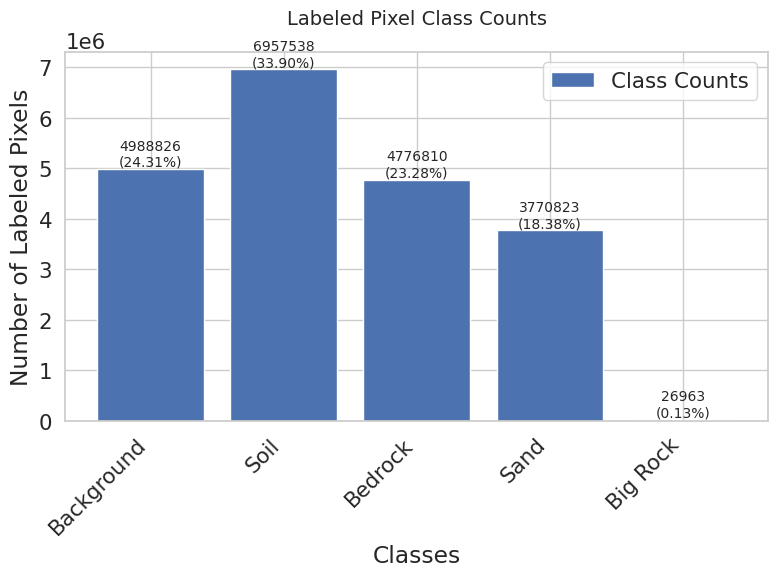

In [ ]:
def plot_class_counts(y_vector, class_labels):
    """
    Plot class counts and frequency percentages for labeled pixels.

    Parameters:
    - y_vector (1D array): Class indices for labeled pixels.
    - class_labels (list of str): Names of the classes.
    """
    # Ensure input is a 1D array of integers
    y_vector = np.ravel(y_vector).astype(int)

    # Calculate class counts
    class_counts = np.bincount(y_vector, minlength=len(class_labels))

    # Calculate frequency percentages
    class_frequencies = class_counts / np.sum(class_counts) * 100

    # Set plot figure size
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))

    # Plot bars for class counts
    x = np.arange(len(class_labels))
    bars = plt.bar(x, class_counts, label='Class Counts')

    # Add count and frequency annotations on top of the bars
    for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
        plt.text(i, count + 5,  # Offset above the bar
                 f'{int(count)}\n({freq:.2f}%)', ha='center', va='bottom', fontsize=10)

    # Customise plot title and labels
    plt.title('Labeled Pixel Class Counts', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Labeled Pixels')

    # Set class labels as x-axis labels with rotation
    plt.xticks(x, class_labels, rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Define class labels
class_labels = [
    "Background",
    "Soil",
    "Bedrock",
    "Sand",
    "Big Rock"
]

# Plot class counts for training data (adjust to y_val or y_test as needed)
plot_class_counts(y_train, class_labels)

# Texture Analysis

We want to show the big variability between textures beloning to the same label, in order to justify our image preprocessing pipeline.

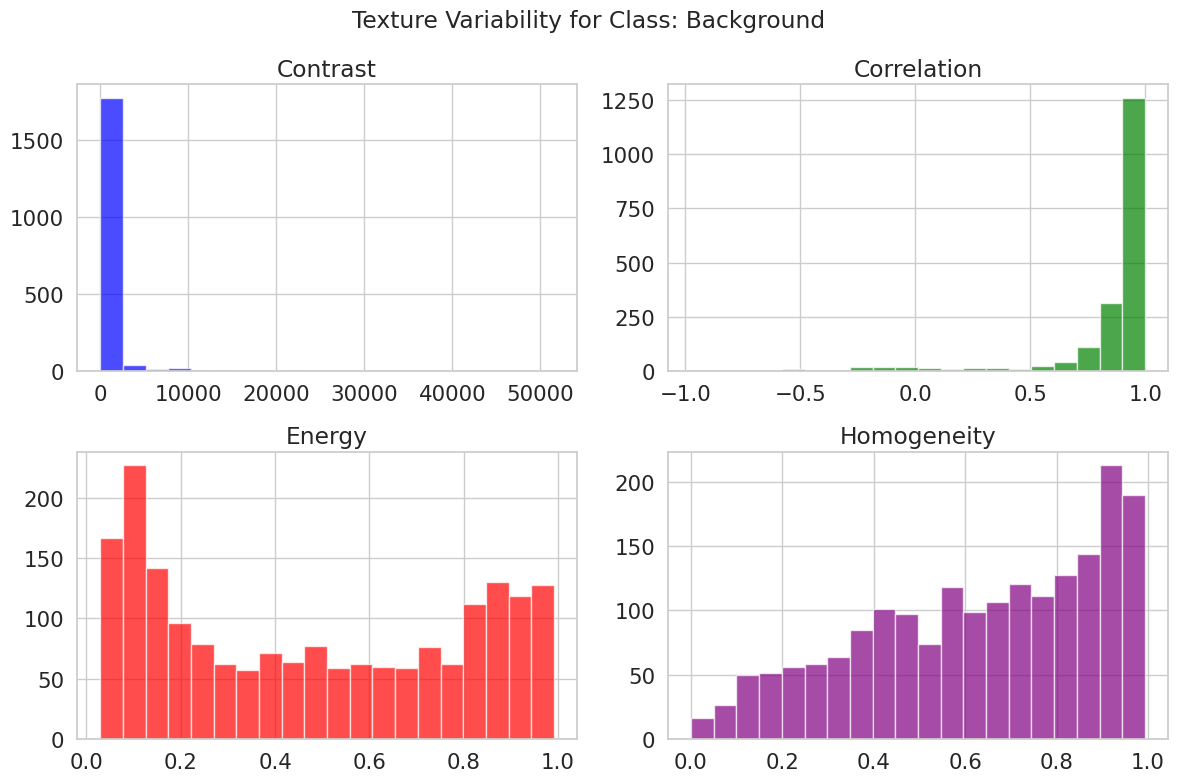

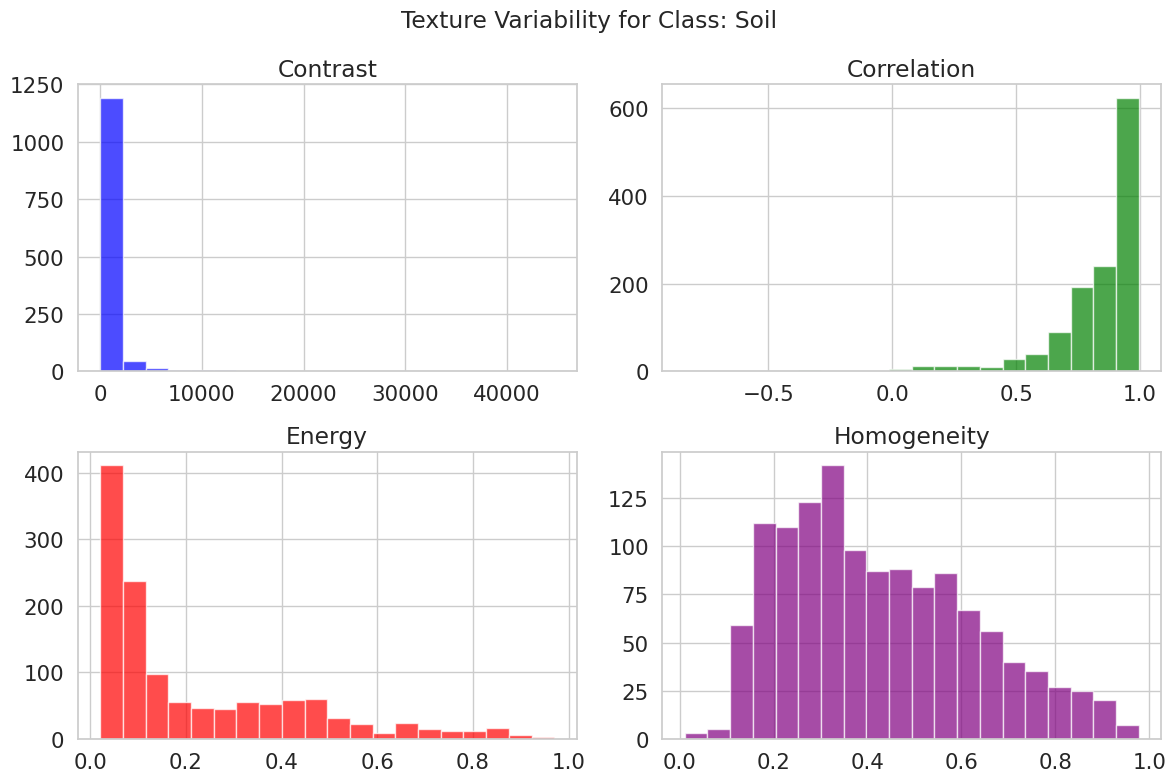

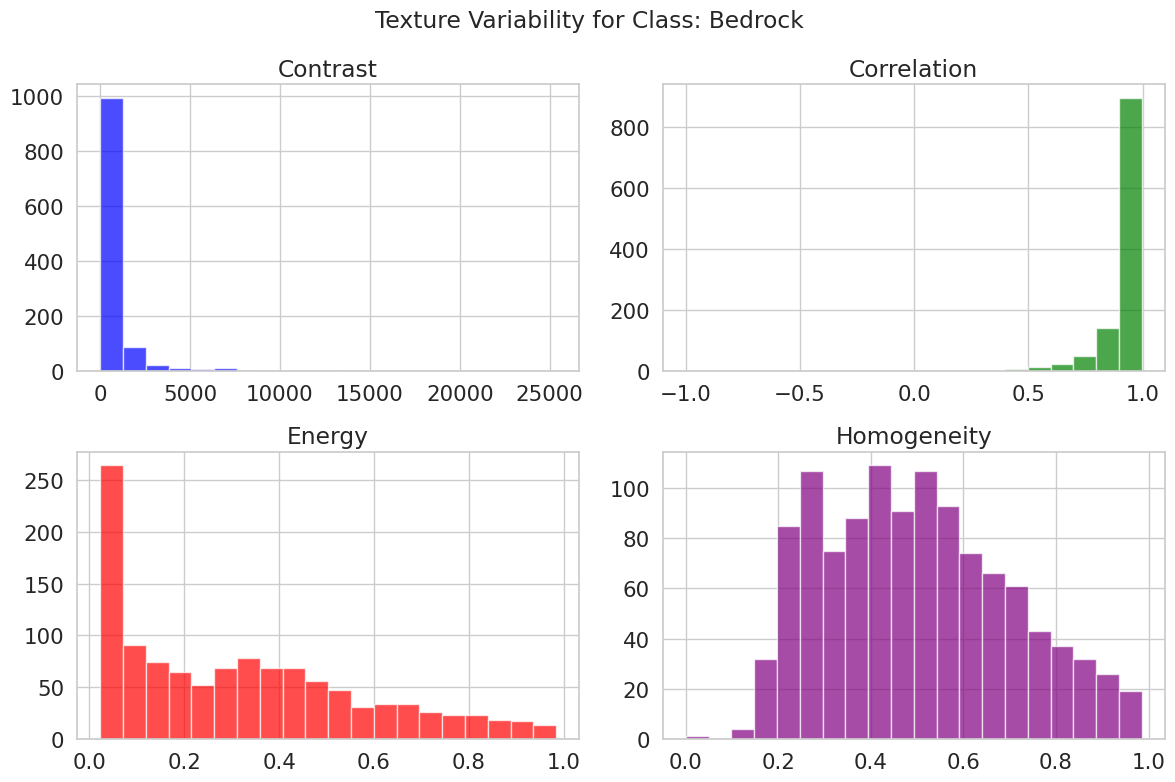

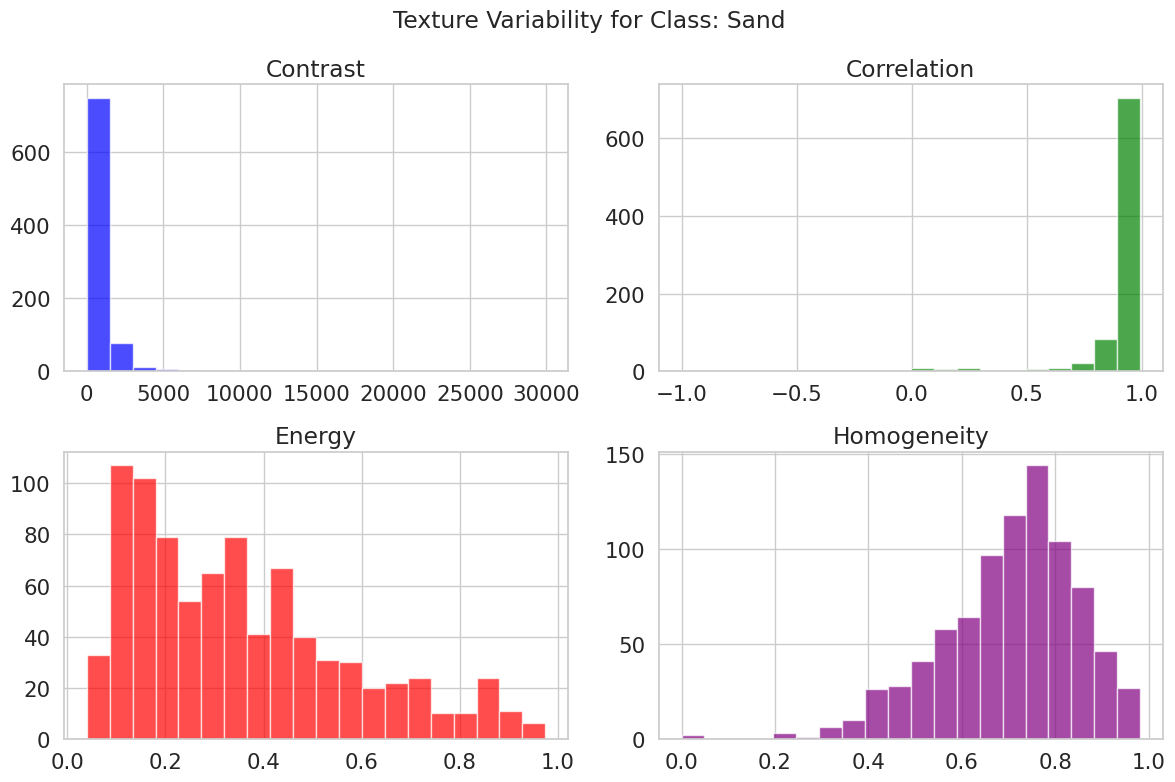

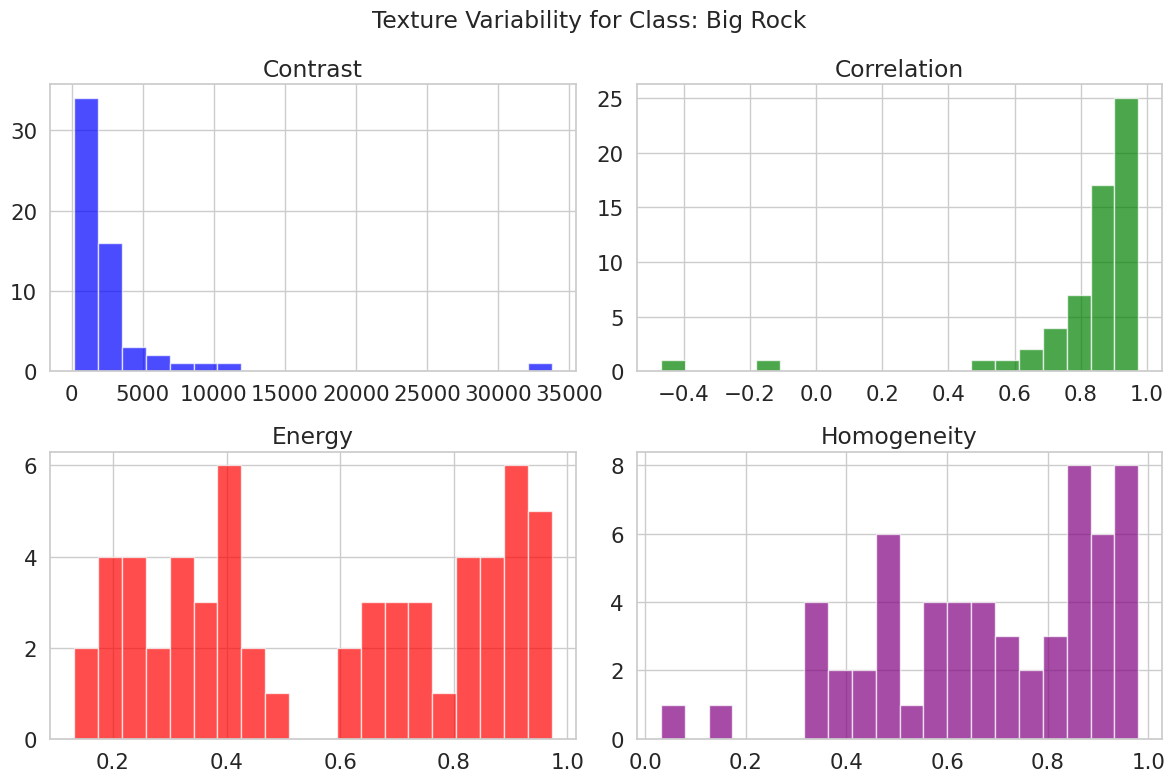

In [ ]:
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import numpy as np

def compute_glcm_features(image, distances, angles):
    """
    Computes GLCM features (contrast, correlation, energy, homogeneity) for a given image.
    """
    if image.ndim != 2:
        raise ValueError("Image must be a 2-dimensional array")

    # Ensure image is an unsigned integer type
    image = np.uint8(255 * image)  # Scale to [0, 255] and convert to uint8

    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
    }
    return features

def analyze_textures_by_class(images, labels, class_labels, distances=[1], angles=[0]):
    """
    Computes and visualizes the distribution of texture features for each class.
    """
    textures_by_class = {cls: [] for cls in class_labels.values()}

    # Compute GLCM features for each image
    for img, label in zip(images, labels):

        for cls in class_labels:
            mask = (label == cls)
            masked_image = img * mask  # Apply the mask

            # Check if the masked region is not empty
            if masked_image.max() > 0:
                # Get the bounding box of the masked region
                rows = np.any(masked_image, axis=1)
                cols = np.any(masked_image, axis=0)
                rmin, rmax = np.where(rows)[0][[0, -1]]
                cmin, cmax = np.where(cols)[0][[0, -1]]

                # Crop the masked image to the bounding box
                cropped_image = masked_image[rmin:rmax+1, cmin:cmax+1]

                # Ensure the cropped image is not too small for GLCM
                if cropped_image.shape[0] > 1 and cropped_image.shape[1] > 1:
                    # Compute GLCM features
                    glcm_features = compute_glcm_features(cropped_image, distances, angles)
                    textures_by_class[class_labels[cls]].append(glcm_features)

    # Visualize texture variability per class
    for cls_name, features in textures_by_class.items():
        if features:
            # Extract individual features
            contrast = [f['contrast'] for f in features]
            correlation = [f['correlation'] for f in features]
            energy = [f['energy'] for f in features]
            homogeneity = [f['homogeneity'] for f in features]

            # Create a figure for the class
            plt.figure(figsize=(12, 8))
            plt.suptitle(f"Texture Variability for Class: {cls_name}")

            plt.subplot(2, 2, 1)
            plt.hist(contrast, bins=20, color='blue', alpha=0.7)
            plt.title('Contrast')

            plt.subplot(2, 2, 2)
            plt.hist(correlation, bins=20, color='green', alpha=0.7)
            plt.title('Correlation')

            plt.subplot(2, 2, 3)
            plt.hist(energy, bins=20, color='red', alpha=0.7)
            plt.title('Energy')

            plt.subplot(2, 2, 4)
            plt.hist(homogeneity, bins=20, color='purple', alpha=0.7)
            plt.title('Homogeneity')

            plt.tight_layout()
            plt.show()

# Example usage
class_labels = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}
analyze_textures_by_class(X_train, y_train, class_labels)

From this we can determine the classes that are going to be difficult to learn features from. Sand and background have a huge variability in their textures and therefore it's going to be difficult to learn general patterns to identify them.

Moreover, we notice the class big rocks is going to be difficult o categorize regardless since it has so few instances compared to other classes.


  - Visualization of Texture Feature Distributions:
    * The histograms generated for each class (e.g., Background, Soil, Bedrock) provide a visual representation of how the four texture features (contrast, correlation, energy, and homogeneity) are distributed within that class.
    * By comparing the shapes and spreads of these histograms across different classes, you can identify:
    + Similarities: If the histograms for a particular texture feature are similar across classes, it may indicate that this feature is not discriminatory for distinguishing between those classes.
    + Differences: If the histograms are distinct, it suggests that this texture feature can help differentiate between classes.
  - Texture Feature Variability:
    * The spread (e.g., standard deviation) of the histograms indicates the variability of each texture feature within a class.
    * A narrow spread implies that the texture feature is consistent within the class, while a wide spread indicates higher variability.
    * By comparing the variability of texture features across classes, you can:
    + Identify classes with more homogeneous textures (narrow spreads).
    + Recognize classes with more heterogeneous textures (wide spreads).
  - Comparison of Texture Features Across Classes:
    * By examining the histograms for each texture feature across multiple classes, you can:
    + Identify dominant features: Determine which texture features are more prevalent in each class.
    + Discover feature correlations: Observe if certain texture features tend to occur together within a class.
    + Uncover class-specific texture patterns: Reveal unique texture patterns that are characteristic of each class.
  - Informing Feature Selection or Engineering:
    * The insights gained from analyzing texture feature distributions can inform:
    + Feature selection: Choose the most discriminatory texture features for your specific problem.
    + Feature engineering: Create new features that capture the unique texture patterns identified in your analysis.

Example Insights:

Suppose you're analyzing the texture distributions for the classes "Soil" and "Bedrock". Your analysis reveals:

  - The "Soil" class has a relatively narrow spread in the energy histogram, indicating consistent texture, while "Bedrock" exhibits a wide spread, suggesting more heterogeneous textures.
  - The correlation histograms for "Soil" and "Bedrock" are distinct, implying that this feature can help differentiate between the two classes.
  - The contrast histograms for both classes are similar, indicating that contrast might not be an effective feature for distinguishing between "Soil" and "Bedrock".

These insights can guide your feature selection or engineering process, ultimately improving the performance of your texture-based classification model.